In [1]:
!pip install -q kaggle
!gdown "1CiOTLdUpSZ3d-2io-tALvhoaqxDVMXw2"

Downloading...
From: https://drive.google.com/uc?id=1CiOTLdUpSZ3d-2io-tALvhoaqxDVMXw2
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 64.0kB/s]


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d "carlolepelaars/camvid"

 99% 570M/575M [00:04<00:00, 78.6MB/s]
100% 575M/575M [00:04<00:00, 128MB/s] 


In [4]:
ls

camvid.zip  kaggle.json  sample_data/


In [ ]:
!unzip camvid.zip

In [6]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [7]:
IMG_SIZE = 256

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch
from PIL import Image
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
sorted(os.listdir("CamVid/train"))[:2]

['0001TP_009210.png', '0001TP_009240.png']

In [10]:

sorted(os.listdir("CamVid/train_labels"))[:2]

['0001TP_009210_L.png', '0001TP_009240_L.png']

In [11]:
train_images = os.listdir("CamVid/train")
test_images = os.listdir("CamVid/test")
val_images = os.listdir("CamVid/val")
train_images[:5]

['Seq05VD_f02400.png',
 '0001TP_009750.png',
 '0016E5_07620.png',
 'Seq05VD_f00420.png',
 'Seq05VD_f01890.png']

In [12]:
print(f"Number of training Images is {len(train_images)}")
print(f"Number of testing Images is {len(test_images)}")
print(f"Number of validation Images is {len(val_images)}")

Number of training Images is 369
Number of testing Images is 232
Number of validation Images is 100


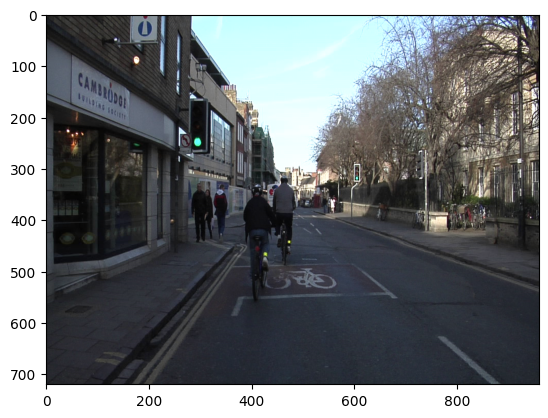

In [13]:
image_path = "CamVid/train/0016E5_08063.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

(-0.5, 959.5, 719.5, -0.5)

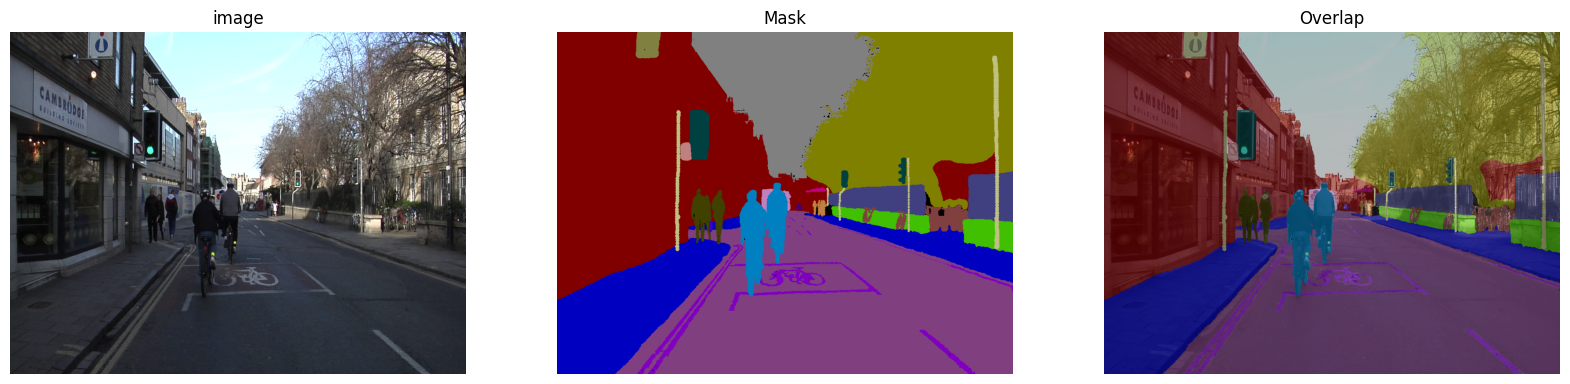

In [14]:
image_path = "CamVid/train/0016E5_08063.png"
mask_path = "CamVid/train_labels/0016E5_08063_L.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(image)
plt.title("image")
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.subplot(133)
plt.imshow(image)
plt.imshow(mask,alpha=.55)
plt.title("Overlap")
plt.axis('off')

In [15]:
classes = pd.read_csv('/content/CamVid/class_dict.csv',index_col=0)
classes.head(10)

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [16]:
class2rgb = {c1:list(classes.loc[c1,:]) for c1 in classes.index}
class2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'SUVPickupTruck': [64, 128, 192],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [17]:
class2idx = {idx:color for idx,color in enumerate(class2rgb.values())}
class2idx

{0: [64, 128, 64],
 1: [192, 0, 128],
 2: [0, 128, 192],
 3: [0, 128, 64],
 4: [128, 0, 0],
 5: [64, 0, 128],
 6: [64, 0, 192],
 7: [192, 128, 64],
 8: [192, 192, 128],
 9: [64, 64, 128],
 10: [128, 0, 192],
 11: [192, 0, 64],
 12: [128, 128, 64],
 13: [192, 0, 192],
 14: [128, 64, 64],
 15: [64, 192, 128],
 16: [64, 64, 0],
 17: [128, 64, 128],
 18: [128, 128, 192],
 19: [0, 0, 192],
 20: [192, 128, 128],
 21: [128, 128, 128],
 22: [64, 128, 192],
 23: [0, 0, 64],
 24: [0, 64, 64],
 25: [192, 64, 128],
 26: [128, 128, 0],
 27: [192, 128, 192],
 28: [64, 0, 64],
 29: [192, 192, 0],
 30: [0, 0, 0],
 31: [64, 192, 0]}

In [18]:
# declare transfomation pipeline this pipeline is used to preprocess image before feeding it to NN
my_trans = transforms.Compose([
    # Randomly crop a square region of size 224 * 244 from input image ,
    # this help in data agumentation and ensures that NN sees different parts of image
    transforms.RandomResizedCrop(IMG_SIZE),
    # flips input image horizontally with probability 0.5
    transforms.RandomHorizontalFlip(),
    # because Pytorch only excepts input tensor we have to convert image into a tensor
    transforms.ToTensor(),
    # image normalization helps in
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

])

In [19]:
def adjust_mask(mask):
    mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
    semantic_map = []
    for colour in list(class2idx.values()):
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)


In [20]:
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
mask = adjust_mask(mask)
mask.shape

(256, 256, 32)

In [21]:
def oneHot2image(output):
  output = np.argmax(output,axis=2)
  rgb_image = np.zeros((IMG_SIZE,IMG_SIZE,3), dtype=np.uint8)
  image = Image.new("RGB", (IMG_SIZE, IMG_SIZE))

  for y in range(IMG_SIZE):
      for x in range(IMG_SIZE):
          pixel_id = output[y][x]
          color = class2idx[pixel_id]
          image.putpixel((x, y), tuple(color))
  return image


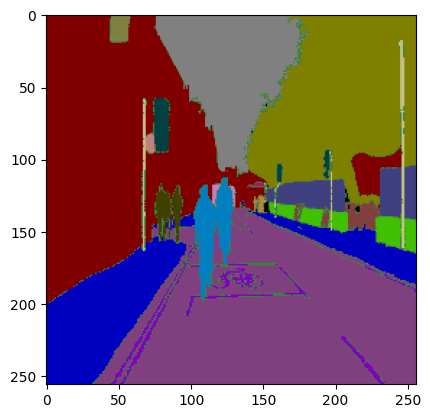

In [22]:
image = oneHot2image(mask)
plt.imshow(image)

In [23]:
class MyDataset(Dataset):

  def __init__(self,images,image_path,mask_path,my_trans,cls2rgb):

    self.images = images
    self.image_path = image_path
    self.mask_path = mask_path
    self.my_trans = my_trans
    self.cls2rgb = cls2rgb

  def __len__(self):

    return len(self.images)

  def adjust_mask(self,mask):
    mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
    semantic_map = []
    for colour in list(self.cls2rgb.values()):
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)




  def __getitem__(self,index):

    image = self.images[index]
    image_id = image.split(".")[0]

    img = Image.open(os.path.join(self.image_path,image)).convert('RGB')
    if self.my_trans is not None:
      img = self.my_trans(img)
    img = img.reshape(3,IMG_SIZE,IMG_SIZE)
    label = os.path.join(self.mask_path,f"{image_id}_L.png")
    label = cv2.imread(label)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    label = self.adjust_mask(label)

    return img,label



In [24]:
train_data = MyDataset(train_images,"CamVid/train","CamVid/train_labels",
                       my_trans,class2idx)
train_loader = DataLoader(train_data,batch_size=8 ,
                          shuffle=True)

In [25]:
sample = next(iter(train_loader))

In [26]:
sample[1].shape

torch.Size([8, 256, 256, 32])

In [27]:
type(sample[0][0])

torch.Tensor

### UNET Network Architecture
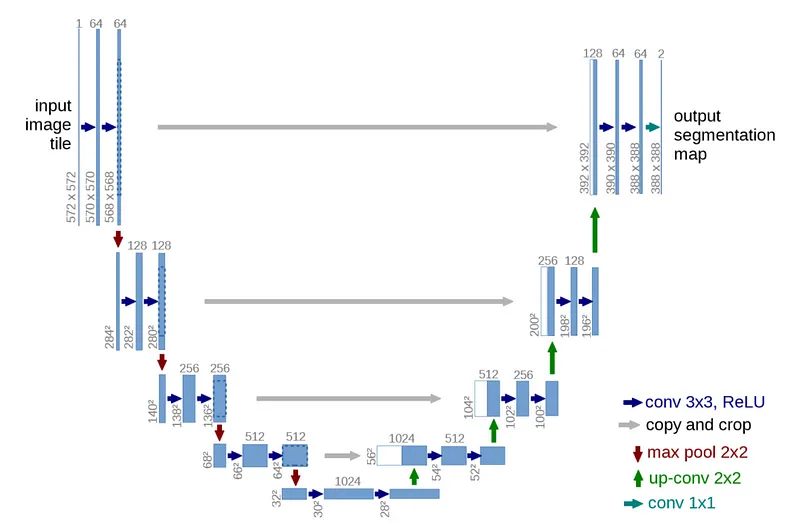

In [28]:
class ConvBlock(nn.Module):

  def __init__(self,in_c,out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_c , out_channels=out_c , kernel_size=3 , padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)
    self.conv2 = nn.Conv2d(in_channels=out_c , out_channels=out_c , kernel_size=3 , padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self,image):

    net = self.conv1(image)
    net = self.bn1(net)
    net = self.relu(net)

    net = self.conv2(net)
    net = self.bn2(net)
    net = self.relu(net)

    return net


In [29]:
class EncoderBlock(nn.Module):

  def __init__(self,in_c , out_c):
    super().__init__()
    self.block = ConvBlock(in_c,out_c)

    self.max_pool = nn.MaxPool2d((2 , 2))

  def forward(self,input):

    x = self.block(input)

    p = self.max_pool(x)

    return x , p

In [30]:
class DecoderBlock(nn.Module):

  def __init__(self,in_c , out_c):
    super().__init__()
    self.tconv = nn.ConvTranspose2d(in_c,out_c , kernel_size=2 , padding=0 , stride=2)
    self.conv = ConvBlock(out_c + out_c , out_c)

  def forward(self,input , skip):

    net = self.tconv(input)
    net = torch.cat([net, skip] , axis = 1)

    net = self.conv(net)

    return net

In [95]:
class UNet(nn.Module):

  def __init__(self):
    super().__init__()

    """ Encoder Block """

    self.encoder1 = EncoderBlock(3 , 64)
    self.encoder2 = EncoderBlock(64 , 128)
    self.encoder3 = EncoderBlock(128, 256)
    self.encoder4 = EncoderBlock(256, 512)
    self.encoder5 = EncoderBlock(512 , 1024)

    """ Bottleneck """
    self.b = ConvBlock(1024, 2048)

    """ Decoder Block """

    self.d1 = DecoderBlock(2048 , 1024)
    self.d2 = DecoderBlock(1024 , 512)
    self.d3 = DecoderBlock(512 , 256)
    self.d4 = DecoderBlock(256 , 128)
    self.d5 = DecoderBlock(128 , 64)

    """ Classifier """
    self.outputs = nn.Conv2d(64, 32, kernel_size=1, padding=0)


    # self.softmax = nn.Sigmoid()


  def forward(self,input):
    s1 , p1 = self.encoder1(input)
    s2 , p2 = self.encoder2(p1)
    s3 , p3 = self.encoder3(p2)
    s4 , p4 = self.encoder4(p3)
    s5 , p5 = self.encoder5(p4)

    b = self.b(p5)

    d1 = self.d1(b , s5)
    d2 = self.d2(d1 , s4)
    d3 = self.d3(d2 , s3)
    d4 = self.d4(d3 , s2)
    d5 = self.d5(d4 , s1)


    output = self.outputs(d5)

    # output = self.softmax(output)
    return output



In [96]:
model = UNet()
model = model.to(device)

In [97]:
image = sample[0][0]
image = image.reshape(-1,3,IMG_SIZE,IMG_SIZE)
image = image.to(device)
output = model(image)

output.shape

torch.Size([1, 32, 256, 256])

In [98]:
epochs_num = 50
loss_fn =smp.losses.DiceLoss(mode='multilabel')
loss_fn2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,
                                          min_lr=1e-6,patience=2,verbose=True)


In [ ]:
model.train()
for epoch in range(epochs_num):

  total_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(images)

    # print(f"out shape is {outputs.shape}")
    # print(f"label shape is {labels.shape}")

    outputs = outputs.reshape(-1,IMG_SIZE,IMG_SIZE,32)

    loss1 = loss_fn(outputs , labels)
    loss2 = loss_fn2(outputs , labels)
    batch_loss = loss1 + loss2
    batch_loss.backward()
    optimizer.step()

    total_loss += batch_loss.item()

  scheduler.step(total_loss)

  print(f"Epoch {epoch+1}/{epochs_num}, Loss: {total_loss / len(train_loader)}")

Epoch 1/50, Loss: 41.628008659849776


In [78]:
image = sample[0][0]
mask = sample[1][0]
image = image.reshape(-1,3,IMG_SIZE,IMG_SIZE)
image = image.to(device)
output = model(image)
output.shape
output = output.cpu().detach().numpy().squeeze()


In [79]:
output = output.reshape(IMG_SIZE,IMG_SIZE,32)

In [80]:
output_mask = oneHot2image(output)

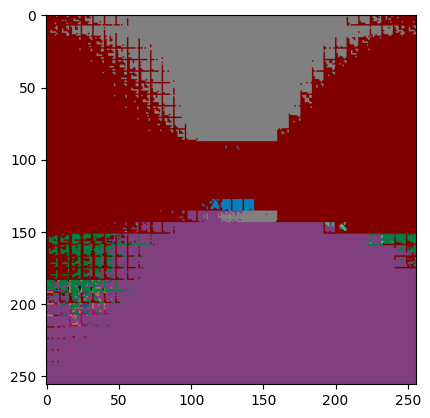

In [81]:
plt.imshow(output_mask)

In [82]:
mask = oneHot2image(mask.cpu().detach().numpy())

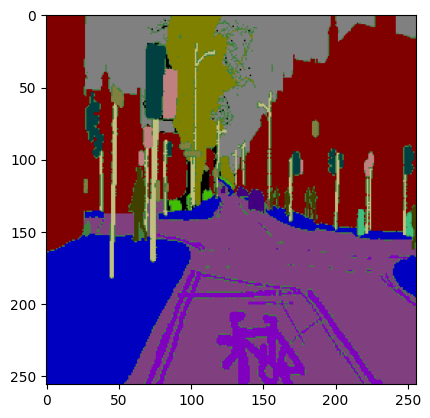

In [83]:
plt.imshow(mask)

### Pretrained Model

In [47]:
base_model = models.segmentation.fcn_resnet101(weights='DEFAULT')

In [48]:
for param in base_model.parameters():
    param.requires_grad = True

In [49]:
class CustomPretrained(nn.Module):

    def __init__(self, base_model):
        super().__init__()

        self.base_model = base_model

        self.conv1 = nn.Conv2d(21, 64, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()

        self.transposed_conv = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=1, padding=1)

    def forward(self, my_input):
        net = base_model(my_input)['out']

        net = self.conv1(net)
        net = self.relu(net)
        net = self.conv2(net)
        net = self.relu(net)

        output = self.transposed_conv(net)

        return output

In [50]:
pre_model = CustomPretrained(base_model)
pre_model = pre_model.to(device)

In [51]:
image = sample[0][0]
image = image.reshape(-1,3,IMG_SIZE,IMG_SIZE)
image = image.to(device)
output = pre_model(image)

output.shape

torch.Size([1, 32, 256, 256])

In [52]:
epochs_num = 50
loss_fn =smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.001)

In [54]:
model.train()
for epoch in range(epochs_num):

  total_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = pre_model(images)

    # print(f"out shape is {outputs.shape}")
    # print(f"label shape is {labels.shape}")

    outputs = outputs.reshape(-1,IMG_SIZE,IMG_SIZE,32)

    loss = loss_fn(outputs , labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs_num}, Loss: {total_loss / len(train_loader)}")

Epoch 1/50, Loss: 0.7313169469224646
Epoch 2/50, Loss: 0.539240743885649
Epoch 3/50, Loss: 0.5190131613548766
Epoch 4/50, Loss: 0.5181046844796932
Epoch 5/50, Loss: 0.5425265095335372
Epoch 6/50, Loss: 0.5248594246012099
Epoch 7/50, Loss: 0.518359844354873
Epoch 8/50, Loss: 0.5172185542735648
Epoch 9/50, Loss: 0.5181806347471603
Epoch 10/50, Loss: 0.5157027415772701
Epoch 11/50, Loss: 0.516359195430228
Epoch 12/50, Loss: 0.5171007596431895
Epoch 13/50, Loss: 0.5158223103969655
Epoch 14/50, Loss: 0.5181790615649934
Epoch 15/50, Loss: 0.5171964352435254
Epoch 16/50, Loss: 0.5162456701410577
Epoch 17/50, Loss: 0.5153431683144671
Epoch 18/50, Loss: 0.5154048090285444
Epoch 19/50, Loss: 0.5170748068931255
Epoch 20/50, Loss: 0.5145009502451471
Epoch 21/50, Loss: 0.5146627432488381
Epoch 22/50, Loss: 0.5141165402341397
Epoch 23/50, Loss: 0.5125789686720422
Epoch 24/50, Loss: 0.5109396456403935
Epoch 25/50, Loss: 0.5114449903051904
Epoch 26/50, Loss: 0.5108738763535277
Epoch 27/50, Loss: 0.511

KeyboardInterrupt: ignored

In [55]:
image = sample[0][0]
mask = sample[1][0]
image = image.reshape(-1,3,IMG_SIZE,IMG_SIZE)
image = image.to(device)
output = pre_model(image)
output.shape
output = output.cpu().detach().numpy().squeeze()


In [56]:
output = output.reshape(IMG_SIZE,IMG_SIZE,32)

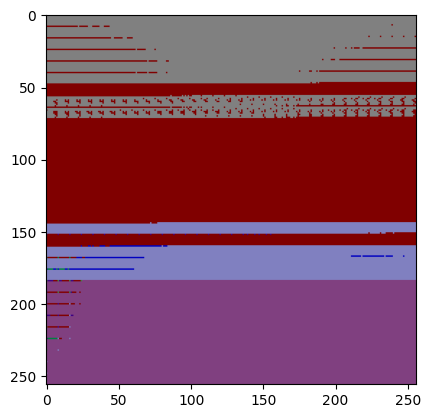

In [57]:
output_mask = oneHot2image(output)
plt.imshow(output_mask)

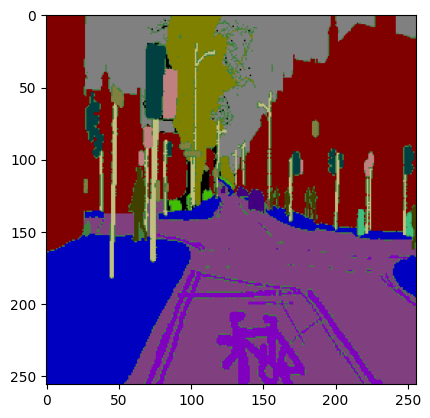

In [58]:
mask = oneHot2image(mask.cpu().detach().numpy())
plt.imshow(mask)

In [ ]:
base_model = models.densenet201(weights='DEFAULT')

In [ ]:
for param in base_model.parameters():
    param.requires_grad = True

In [ ]:
class CutsomModel(nn.Module):

  def __init__(self,base_model):
    super().__init__()

    self.base_model = base_model

    self.conv = nn.Conv2d(1920, 256, kernel_size=1)
    self.tconv = nn.ConvTranspose2d(256, 32, kernel_size=67, stride=27, padding=0)

    self.relu = nn.ReLU()

  def forward(self,input):

    net = self.base_model.features(input)
    # print(net.shape)
    net = self.conv(net)

    net = self.relu(net)

    net = self.tconv(net)

    return net

In [ ]:
pretrained = CutsomModel(base_model)
pretrained = pretrained.to(device)

In [ ]:
image = sample[0][0]
image = image.reshape(-1,3,IMG_SIZE,IMG_SIZE)
image = image.to(device)
output = pretrained(image)
print(output.shape)

torch.Size([1, 32, 256, 256])


In [ ]:
epochs_num = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained.parameters(), lr=0.01)

In [ ]:
for epoch in range(epochs_num):

  total_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = pretrained(images)

    # print(f"out shape is {outputs.shape}")
    # print(f"label shape is {labels.shape}")

    outputs = outputs.reshape(-1,IMG_SIZE,IMG_SIZE,32)

    loss = loss_fn(outputs , labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs_num}, Loss: {total_loss / len(train_loader)}")

Epoch 1/50, Loss: 40.70921122774165
Epoch 2/50, Loss: 38.292503356933594
Epoch 3/50, Loss: 38.10104426931828
Epoch 4/50, Loss: 38.00873947143555
Epoch 5/50, Loss: 37.8244717374761
Epoch 6/50, Loss: 37.829200014154964
Epoch 7/50, Loss: 37.69850523928378
Epoch 8/50, Loss: 37.59014275733461
Epoch 9/50, Loss: 38.00289697850004
Epoch 10/50, Loss: 37.76340500851895
Epoch 11/50, Loss: 37.519096131020405
Epoch 12/50, Loss: 37.68181683154816
Epoch 13/50, Loss: 37.69038529091693
Epoch 14/50, Loss: 37.49159175791639
Epoch 15/50, Loss: 37.60601904037151
Epoch 16/50, Loss: 37.66054210257023


KeyboardInterrupt: ignored

In [ ]:
output = pretrained(image)
output = output.cpu().detach().numpy().squeeze()
output = output.reshape(IMG_SIZE,IMG_SIZE,32)

In [ ]:
output_mask = oneHot2image(output)

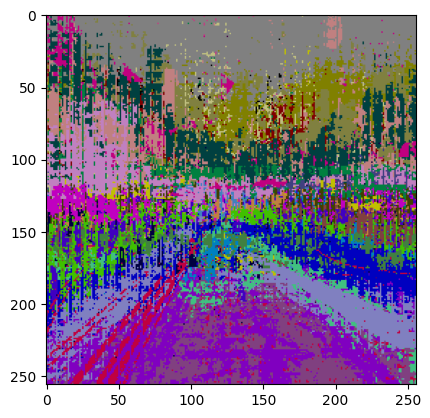

In [ ]:
plt.imshow(output_mask)